In [ ]:
!pip install torchmetrics --quiet
!pip install accelerate -U --quiet
!pip install transformers --quiet
!pip install datasets --quiet
!pip install evaluate --quiet

In [ ]:
import os
import sys
import pathlib
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR, CyclicLR
from torch.utils.data import DataLoader

import transformers
from transformers import AutoModel, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoTokenizer, pipeline
from transformers import get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments

from datasets import Dataset, DatasetDict, load_dataset

In [ ]:
import google.colab
google.colab.drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/datasets/professional-text-legal-medical/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
NUM_EPOCHS = 1
learning_rate = 2e-6
decay = 0.01
ckpt = 'theSOL1/kolongformer-base-4096'
main_path = Path('/content/drive/MyDrive/projects/ExpertLLM/')
SAMPLE_SIZE = 18000

In [ ]:
class TokenizeMapWrapper:
    def __init__(self, tokenizer, features, option=None):
        if option is None:
            option = {
                'max_length': 4096,
                'truncation': True,
                'padding': 'max_length',
            }

        self.option = option
        self.features = features
        self.tokenizer = tokenizer

    def __call__(self, batch):
        for feature in self.features:
            tokenized_output = self.tokenizer(batch[feature], **self.option)
        return tokenized_output

    def __repr__(self):
        return f'{self.__class__.__name__}(tokenizer={self.tokenizer})'

tokenizer = AutoTokenizer.from_pretrained(ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
tokenizer_type = ckpt.split('-')[1]
if (main_path / f'data/law_data_{tokenizer_type}').exists():
    law_data = DatasetDict.load_from_disk(str(main_path / f'data/law_data_{tokenizer_type}'))
else:
    law_data = dict()
    law_data['train'] = pd.read_json('Training_legal.json')['data'].apply(lambda x: '\n'.join([x['category'], x['keyword'][0] if len(x['keyword']) != 0 else '', x['text']]))
    law_data['val'] = pd.read_json('Validation_legal.json')['data'].apply(lambda x: '\n'.join([x['category'], x['keyword'][0] if len(x['keyword']) != 0 else '', x['text']]))

    law_data['train'] = pd.DataFrame({'text': law_data['train']})
    law_data['val'] = pd.DataFrame({'text': law_data['val']})

    law_data = DatasetDict({
        'train': Dataset.from_pandas(law_data['train']),
        'val': Dataset.from_pandas(law_data['val'])
    })

    law_data = law_data.map(TokenizeMapWrapper(tokenizer, ['text']), batched=True)
    law_data.save_to_disk(str(main_path / f'data/law_data_{tokenizer_type}'))

if (main_path / f'data/medical_data_{tokenizer_type}').exists():
    medical_data = DatasetDict.load_from_disk(str(main_path / f'data/medical_data_{tokenizer_type}'))
else:
    medical_data = dict()
    medical_data['train'] = pd.read_json('Training_medical.json')['data'].apply(lambda x: '\n'.join([x['category'], x['keyword'][0] if len(x['keyword']) != 0 else '', x['text']]))
    medical_data['val'] = pd.read_json('Validation_medical.json')['data'].apply(lambda x: '\n'.join([x['category'], x['keyword'][0] if len(x['keyword']) != 0 else '', x['text']]))

    medical_data['train'] = pd.DataFrame({'text': medical_data['train']})
    medical_data['val'] = pd.DataFrame({'text': medical_data['val']})

    medical_data = DatasetDict({
        'train': Dataset.from_pandas(medical_data['train']),
        'val': Dataset.from_pandas(medical_data['val'])
    })

    medical_data = medical_data.map(TokenizeMapWrapper(tokenizer, ['text']), batched=True)
    medical_data.save_to_disk(str(main_path / f'data/medical_data_{tokenizer_type}'))

In [ ]:
law_model = AutoModelForMaskedLM.from_pretrained(ckpt).to('cuda')

In [ ]:
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=0.15)

In [ ]:
law_dataset = (law_data['train'].remove_columns('text')
                                .shuffle()
                                .select(range(SAMPLE_SIZE))
                                )
law_train_dataloader = DataLoader(law_dataset, batch_size=2, shuffle=True, collate_fn=data_collator)
law_optimizer = AdamW(law_model.parameters(), lr=learning_rate, weight_decay=decay)
law_scheduler = get_linear_schedule_with_warmup(law_optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(law_train_dataloader) * NUM_EPOCHS)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
law_model.to(device)
progress_bar = tqdm(range(len(law_train_dataloader)))
law_loss_lt = []
for epoch in range(NUM_EPOCHS):
    for batch in law_train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = law_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        law_loss_lt.append(loss.item())

        loss.backward()
        law_optimizer.step()
        law_scheduler.step()
        law_optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: >

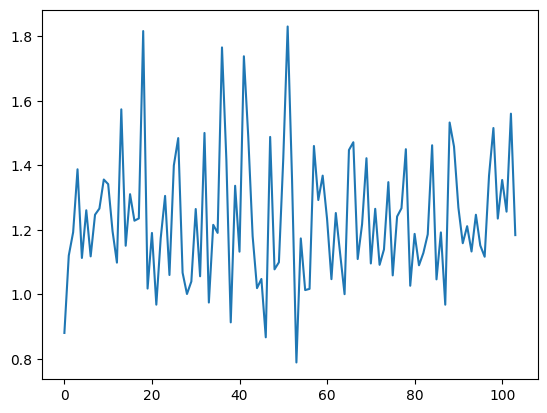

In [ ]:
law_loss_series = pd.Series(law_loss_lt)
law_loss_series.plot()

In [ ]:
medical_model = AutoModelForMaskedLM.from_pretrained(ckpt).to('cuda')

In [ ]:
medical_dataset = (law_data['train'].remove_columns('text')
                                .shuffle()
                                .select(range(SAMPLE_SIZE))
                                )
medical_train_dataloader = DataLoader(medical_dataset, batch_size=2, shuffle=True, collate_fn=data_collator)
medical_optimizer = AdamW(medical_model.parameters(), lr=learning_rate, weight_decay=decay)
medical_scheduler = get_linear_schedule_with_warmup(medical_optimizer,
                                                    num_warmup_steps=0,
                                                    num_training_steps=len(law_train_dataloader) * NUM_EPOCHS)

medical_model.to(device)
progress_bar = tqdm(range(len(law_train_dataloader)))
medical_loss_lt = []
for epoch in range(NUM_EPOCHS):
    for batch in law_train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = medical_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        medical_loss_lt.append(loss.item())

        loss.backward()
        medical_optimizer.step()
        medical_scheduler.step()
        medical_optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
law_training_args = TrainingArguments(
    output_dir=str(main_path / f'models/law_{tokenizer_type}'),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=decay,
)

law_trainer = Trainer(
    model=law_model,
    args=law_training_args,
    train_dataset=law_dataset,
    data_collator=data_collator,
)

law_trainer.save_model()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
medical_training_args = TrainingArguments(
    output_dir=str(main_path / f'models/medical_{tokenizer_type}'),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=decay,
)

medical_trainer = Trainer(
    model=medical_model,
    args=medical_training_args,
    train_dataset=medical_dataset,
    data_collator=data_collator,
)

medical_trainer.save_model()